In [1]:
from gensim import corpora, models, similarities
from pymystem3 import Mystem
from many_stop_words import get_stop_words
import opencorpora
import numpy as np
import pandas as pd

In [2]:
reader = opencorpora.CorpusReader('data/opencorpora/annot.opcorpora.xml')

In [3]:
ru_stopwords = get_stop_words('ru')

In [4]:
stem = Mystem(entire_input=False)

In [29]:
docs = [list(filter(lambda x: not x in ru_stopwords, stem.lemmatize(doc.raw()))) for doc in reader.iter_documents()]

In [31]:
dictionary = corpora.Dictionary(docs)

In [32]:
dictionary.filter_tokens([tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1])
dictionary.compactify()

In [33]:
dictionary.save('data/opencorpora/opencorpora.dict')

In [34]:
corpora.MmCorpus.serialize('data/opencorpora/opencorpora_corpus.mm', list(map(dictionary.doc2bow, docs)))

In [35]:
df = pd.read_csv('data/criminal_code.csv')
df['lemmas'] = df['lemmas'].map(eval)

In [36]:
df['corpus'] = df['lemmas'].map(dictionary.doc2bow)

In [37]:
corpora.MmCorpus.serialize('data/opencorpora/criminal_code_corpus.mm', df['corpus'].tolist())

In [22]:
corpus = corpora.MmCorpus('data/opencorpora/criminal_code_corpus.mm')

In [13]:
tf_idf = models.TfidfModel(corpus=corpus)

In [28]:
tf_idf.save('data/opencorpora/tfidf/opencorpora_tfidf.model')

In [30]:
tf_idf = models.TfidfModel.load('data/opencorpora/tfidf/opencorpora_tfidf.model')

In [16]:
def map_vector(vector, size):
    a = np.zeros(size)
    for n, value in vector:
        a[n] = value
    return a

In [17]:
from scipy.spatial.distance import cosine

In [18]:
df['tfidf'] = df['corpus'].map(lambda text: map_vector(tf_idf[text], len(dictionary)))

In [23]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [20]:
tsne = TSNE().fit_transform(df['tfidf'].tolist())

In [24]:
pca = PCA(n_components=2).fit_transform(df['tfidf'].tolist())

In [21]:
import matplotlib.pyplot as plt

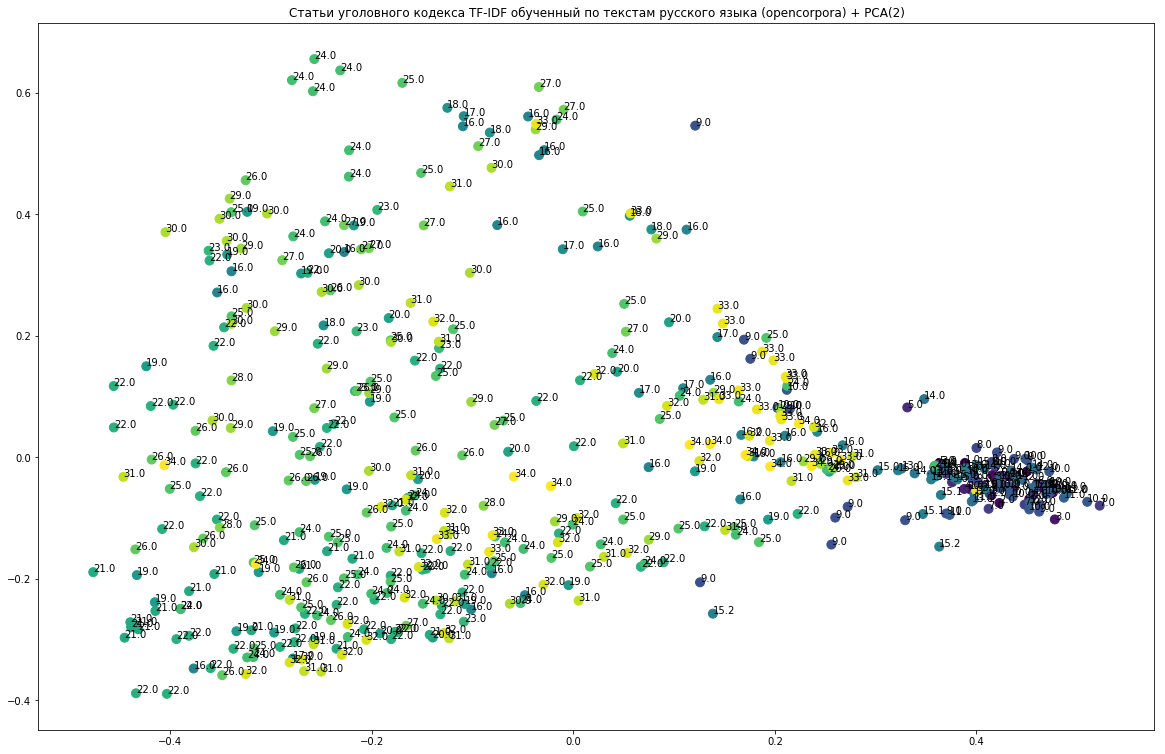

In [26]:
fig, ax = plt.subplots(figsize=(20, 13))
ax.scatter(x=pca[:,0], y=pca[:,1], c=df['chapter'], s=80)
for i, txt in enumerate(df['chapter']):
    ax.annotate(txt, (pca[i,0], pca[i,1]))

_ = ax.set_title('Статьи уголовного кодекса TF-IDF обученный по текстам русского языка (opencorpora) + PCA(2)')

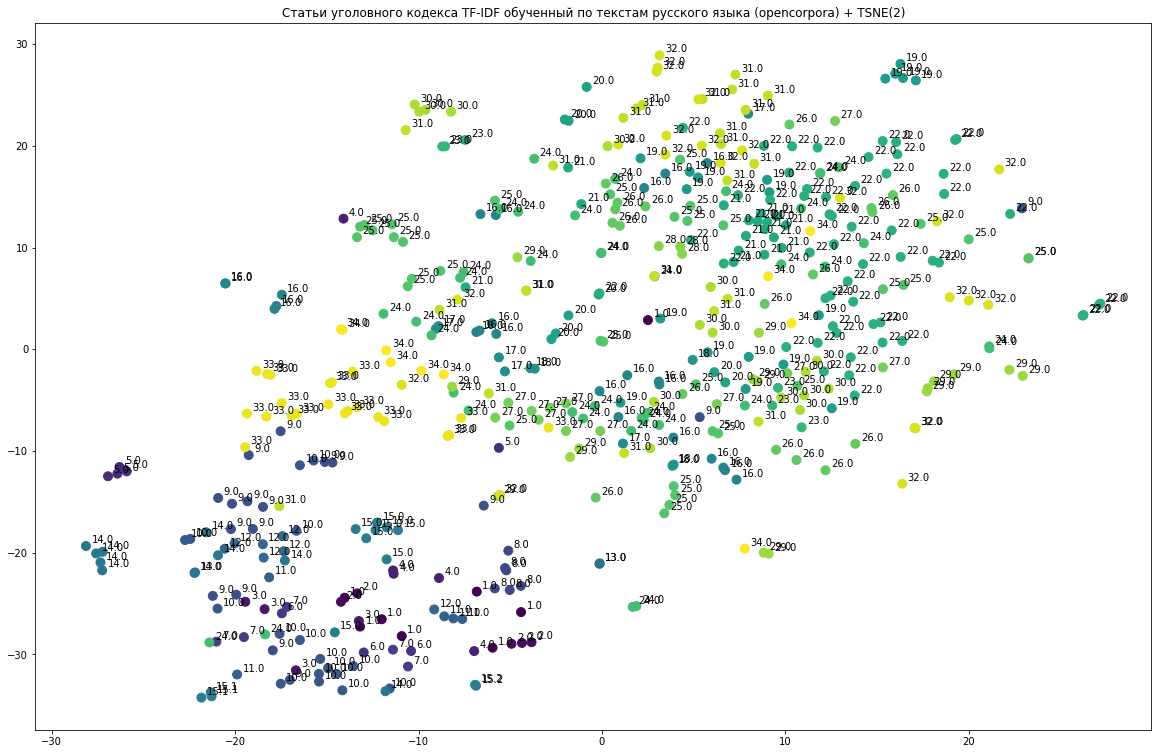

In [22]:
fig, ax = plt.subplots(figsize=(20, 13))
ax.scatter(x=tsne[:,0], y=tsne[:,1], c=df['chapter'], s=80)
for i, txt in enumerate(df['chapter']):
    ax.annotate(txt, (tsne[i,0], tsne[i,1]), xytext=(tsne[i,0]+.3, tsne[i,1]+.3))

_ = ax.set_title('Статьи уголовного кодекса TF-IDF обученный по текстам русского языка (opencorpora) + TSNE(2)')